Custom Model Implementation - Stefano Maxenti - Riccardo Mencucci - "team_durian"

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# The following lines are needed in Gradient Paperspace because these libraries are not installed by default
!pip install --upgrade pip
!pip install scipy sklearn pandas seaborn pillow visualkeras

In [4]:
import os
import tensorflow as tf
import numpy as np
import visualkeras

SEED = 1234
tf.random.set_seed(SEED)  

# Get current working directory
cwd = os.getcwd()

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True # we apply data augmentation even though the dataset has been already augmented offline by Augmentor

# Create training ImageDataGenerator object
if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(rotation_range=10,
                                        width_shift_range=50,
                                        height_shift_range=50,
                                        zoom_range=0.5,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='constant',
                                        shear_range=0.5,
                                        brightness_range=(0.1,0.4),
                                        cval=0,
                                        rescale=1./255)
else:
    train_data_gen = ImageDataGenerator(rescale=1./255)

valid_data_gen = ImageDataGenerator(rescale=1./255)

In [6]:
# Create generators to read images from dataset directory
# -------------------------------------------------------
    dataset_dir = ('DATASET_AUG/')

# Batch size
bs = 64 # it seems a good compromise between speed and frequent updates of the weights

# img shape - images are resized to make the network train much faster
img_h = 128
img_w = 128

num_classes=14

decide_class_indices = False
if decide_class_indices:
    classes = ['Apple',       # 0
               'Blueberry',           # 1
               'Cherry',    # 2
               'Corn',              # 3
               'Grape',          # 4
               'Orange',          # 5
               'Peach',   # 6
               'Pepper',             # 7
               'Potato',            # 8
               'Raspberry',         # 9
               'Soybean',             # 10
               'Squash',       # 11
               'Strawberry',  # 12
               'Tomato'     # 13
                ]        
else:
    classes=None

# Training
training_dir = os.path.join(dataset_dir, 'train')
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               batch_size=bs,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               target_size=(img_h,img_w),
                                               color_mode='rgb',
                                               seed=SEED)  # targets are directly converted into one-hot vectors

# Validation
validation_dir = os.path.join(dataset_dir, 'val')
valid_gen = valid_data_gen.flow_from_directory(validation_dir,
                                               batch_size=bs, 
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=False,
                                               target_size=(img_h,img_w),
                                               color_mode='rgb',
                                               seed=SEED)

Found 18541 images belonging to 14 classes.
Found 6187 images belonging to 14 classes.


In [4]:
# Architecture: Features extraction -> Classifier
model = None
start_f = 16
depth = 3

model = tf.keras.Sequential()

# Features extraction
for i in range(depth):

    if i == 0:
        input_shape = [img_h, img_w, 3]
    else:
        input_shape=[None]

    # Conv block: Conv2D -> Activation -> Pooling
    model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                     kernel_size=(3, 3),
                                     strides=(1, 1),
                                     padding='same',
                                     activation = 'relu', # activation function
                                     kernel_initializer = tf.keras.initializers.GlorotUniform(SEED),
                                     input_shape=input_shape))
    
    model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                     kernel_size=(3, 3),
                                     strides=(1, 1),
                                     padding='same',
                                     activation = 'relu', # activation function
                                     kernel_initializer = tf.keras.initializers.GlorotUniform(SEED),
                                     input_shape=[None]))
    
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))#, strides=(2,2)))
    start_f *= 2
    
# Classifier
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(units=768, activation='relu'))
model.add(tf.keras.layers.Dropout(0.8, seed=42)) # very high, it should make training more resilient
model.add(tf.keras.layers.Dense(units=512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3, seed=42))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5, seed=42))
model.add(tf.keras.layers.Dense(units=32, activation='relu'))
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

2021-11-27 10:08:44.797527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 10:08:44.809742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 10:08:44.810399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 10:08:44.812680: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 10:08:44.813314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        1

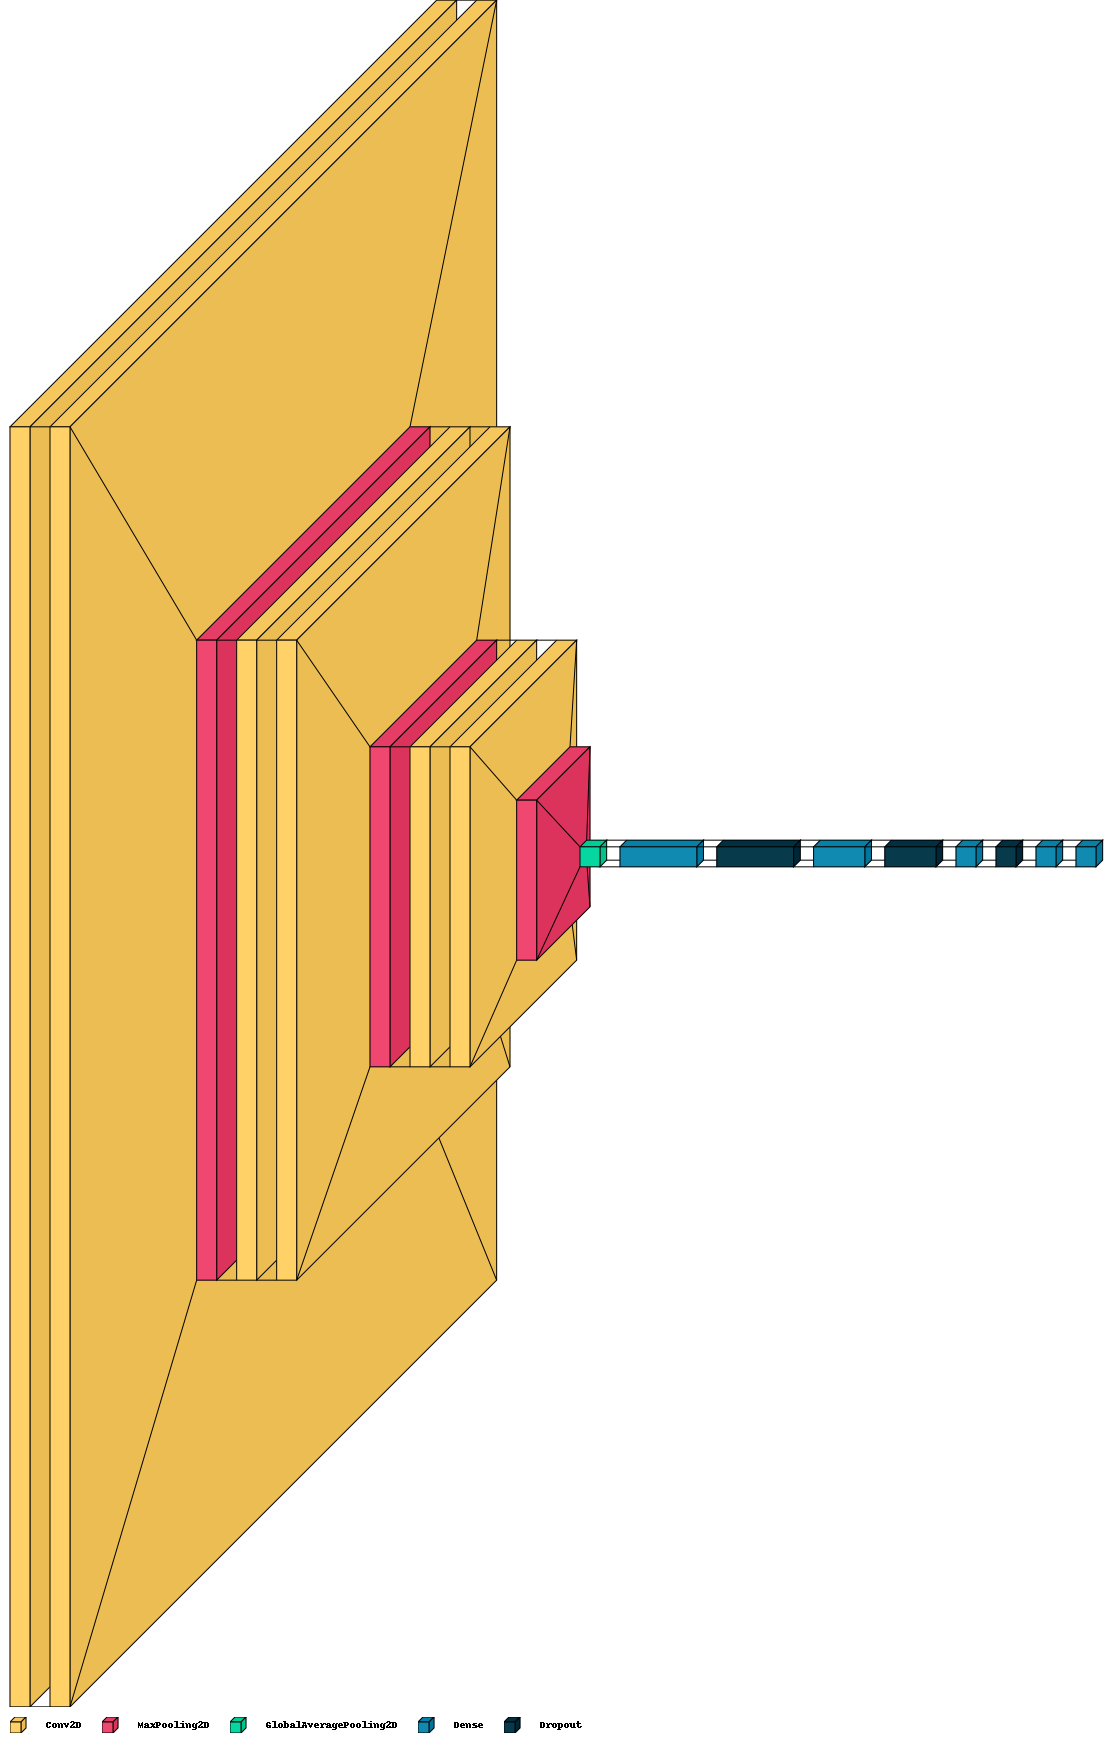

In [38]:
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=10)

In [5]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.CategoricalCrossentropy()
# -------------------


# learning rate
optimizer = tf.keras.optimizers.Adam()
# -------------------

# Validation metrics
metrics = ['accuracy']
# -------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [7]:
import os
from datetime import datetime


cwd = os.getcwd()

exps_dir = os.path.join('classification_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

#now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'FINAL_CUSTOM' # in the output below, we use "20211127_noadaptive_dataset24"

exp_dir = os.path.join(exps_dir, model_name)# + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_best.ckpt'), 
                                                   save_weights_only=False, save_best_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=20)
    callbacks.append(es_callback)

In [ ]:
model.fit(x=train_gen,
          initial_epoch=0,
          epochs=100,
          steps_per_epoch=len(train_gen),
          validation_data=valid_gen,
          validation_steps=len(valid_gen), 
          callbacks=callbacks)

2021-11-27 10:09:07.730230: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2021-11-27 10:09:09.785970: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204


290/290 [==============================] - 234s 794ms/step - loss: 2.4582 - accuracy: 0.2487 - val_loss: 2.3353 - val_accuracy: 0.2504


2021-11-27 10:13:02.255553: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: classification_experiments/20211127_noadaptive_dataset24/ckpts/cp_best.ckpt/assets
Epoch 2/100
290/290 [==============================] - 331s 1s/step - loss: 2.3164 - accuracy: 0.2729 - val_loss: 2.3699 - val_accuracy: 0.2454
Epoch 3/100
290/290 [==============================] - 339s 1s/step - loss: 2.2330 - accuracy: 0.3083 - val_loss: 2.2459 - val_accuracy: 0.3063
INFO:tensorflow:Assets written to: classification_experiments/20211127_noadaptive_dataset24/ckpts/cp_best.ckpt/assets
Epoch 4/100
290/290 [==============================] - 362s 1s/step - loss: 2.1435 - accuracy: 0.3418 - val_loss: 2.0685 - val_accuracy: 0.3483
INFO:tensorflow:Assets written to: classification_experiments/20211127_noadaptive_dataset24/ckpts/cp_best.ckpt/assets
Epoch 5/100
290/290 [==============================] - 365s 1s/step - loss: 2.0086 - accuracy: 0.3799 - val_loss: 2.0988 - val_accuracy: 0.3682
Epoch 6/100
290/290 [==============================] - 358s 1s/step - 

In [9]:
# Unfortunately we ran out of Gradient time, so we need to start back from the best model (epoch 49)
model.fit(x=train_gen,
          initial_epoch=49,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(train_gen),
          validation_data=valid_gen,
          validation_steps=len(valid_gen), 
          #class_weight=class_weights,
          callbacks=callbacks)

2021-11-27 14:50:58.415038: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 50/100


2021-11-27 14:51:00.282276: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204
2021-11-27 14:51:02.787523: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


290/290 [==============================] - 267s 904ms/step - loss: 0.5323 - accuracy: 0.8409 - val_loss: 0.3402 - val_accuracy: 0.9071


2021-11-27 14:55:25.637828: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: classification_experiments/20211127_noadaptive_dataset24/ckpts/cp_best.ckpt/assets
Epoch 51/100
290/290 [==============================] - 160s 551ms/step - loss: 0.5248 - accuracy: 0.8467 - val_loss: 0.3628 - val_accuracy: 0.9011
Epoch 52/100
290/290 [==============================] - 136s 471ms/step - loss: 0.5324 - accuracy: 0.8446 - val_loss: 0.4103 - val_accuracy: 0.8867
Epoch 53/100
290/290 [==============================] - 267s 919ms/step - loss: 0.5176 - accuracy: 0.8463 - val_loss: 0.3539 - val_accuracy: 0.9003
Epoch 54/100
290/290 [==============================] - 65s 222ms/step - loss: 0.5017 - accuracy: 0.8494 - val_loss: 0.3053 - val_accuracy: 0.9090
INFO:tensorflow:Assets written to: classification_experiments/20211127_noadaptive_dataset24/ckpts/cp_best.ckpt/assets
Epoch 55/100
290/290 [==============================] - 69s 239ms/step - loss: 0.4962 - accuracy: 0.8554 - val_loss: 0.4166 - val_accuracy: 0.8833
Epoch 56/100
290/290 [====

In [12]:
model.fit(x=train_gen,
          initial_epoch=100,
          epochs=150,  #### set repeat in training dataset
          steps_per_epoch=len(train_gen),
          validation_data=valid_gen,
          validation_steps=len(valid_gen), 
          #class_weight=class_weights,
          callbacks=callbacks)

Epoch 101/150
290/290 [==============================] - 214s 740ms/step - loss: 0.3096 - accuracy: 0.9098 - val_loss: 0.2116 - val_accuracy: 0.9513
Epoch 102/150
290/290 [==============================] - 197s 678ms/step - loss: 0.3391 - accuracy: 0.9032 - val_loss: 0.1896 - val_accuracy: 0.9547
Epoch 103/150
290/290 [==============================] - 150s 519ms/step - loss: 0.3157 - accuracy: 0.9086 - val_loss: 0.2482 - val_accuracy: 0.9417
Epoch 104/150
290/290 [==============================] - 240s 827ms/step - loss: 0.3182 - accuracy: 0.9092 - val_loss: 0.2182 - val_accuracy: 0.9428
Epoch 105/150
290/290 [==============================] - 64s 221ms/step - loss: 0.2919 - accuracy: 0.9155 - val_loss: 0.1544 - val_accuracy: 0.9612
INFO:tensorflow:Assets written to: classification_experiments/20211127_noadaptive_dataset24/ckpts/cp_best.ckpt/assets
Epoch 106/150
290/290 [==============================] - 186s 641ms/step - loss: 0.3132 - accuracy: 0.9103 - val_loss: 0.2597 - val_accura

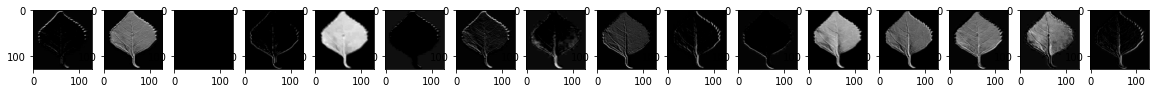

In [36]:
# Let's visualize the activations of our network
from PIL import Image

test_iter = iter(valid_gen)

# Get a test image
test_img = next(valid_gen)[0]
test_img = test_img[0]

# Visualize the image
Image.fromarray(np.uint8(np.array(test_img)*255.))

# Get the activations (the output of each ReLU layer)
layer_outputs = [layer.output for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
# We can do it by creating a new model (activation_model) with model.input as input 
# and all the ReLU activations as output
activation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)
# Finally we get the output values given the imput test image
activations = activation_model.predict(tf.expand_dims(test_img, 0))

import matplotlib.pyplot as plt
%matplotlib inline
def display_activation(activations, act_index): 
    # activations: list of all the activations
    # act_index: the layer we want to visualize (an int in [0, network depth) )
    activation = activations[act_index]
    activation = tf.image.resize(activation, size=[128, 128])
    col_size = activations[0].shape[-1]
    row_size = 1 + act_index
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(8*2.5, 8*1.5), squeeze=False)
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1
display_activation(activations, 0)

In [20]:
# Print Confusion Matrix and Classification Report (Precision, Recall, and F1-score) on the validation set
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

Y_prediction = model.predict_generator(valid_gen, len(valid_gen))
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_prediction,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = valid_gen.classes
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
class_report = classification_report(Y_true, Y_pred_classes, 
                                     target_names=valid_gen.class_indices.keys())  # target_names must be ordered depending on the class labels
print('Confusion Matrix:')
print(confusion_mtx)
print()
print('Classification Report:')
print(class_report)

/usr/local/lib/python3.9/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix:
[[ 352    6    2    1    1    0    1    0    0    0    6    0    1    2]
 [   0  242    0    0    0    0    0    0    0    0    0    0    0    0]
 [   1    1  262    0    0    2    1    3    0    0    0    0    0    1]
 [   0    2    2  418    2    1    0    0    0    0    0    1    1    0]
 [   0    0    0    0  479    0    1    0    0    0    0    1    4    5]
 [   0    1    0    0    0  553    0    3    0    0    0    0    0    5]
 [  12    1    0    0    0    0  352    3    0    0    0    0    0    2]
 [   1    0    2    0    0    0    0  312    0    0    0    0    0    2]
 [   0    0    0    0    0    0    0    1  288    0    3    0    2   10]
 [   0    1    0    0    0    0    0    3    0  185    1    0    1    0]
 [   2    2    0    0    0    0    0    5    8    0  511    0    0    1]
 [   0    2    0    0    1    0    0    0    0    2    0  260    4    0]
 [   0    1    0    0    4    0    0    0    1    3    0    0  282    3]
 [   3    1    2    5    0    1  